In [61]:
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

from utils import GLOBAL, functions

In [62]:
import pandas as pd
import nflfastpy as nfl
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import HTML

In [63]:
year = 2020

pbp_df = nfl.load_pbp_data(year=year)

In [64]:
# Help find relevant stat column based on search term

def search_columns(search_term):
    for column in pbp_df.columns:
        if search_term in column:
            print(column)

# Player profiles/team logos

TODO when ben decides to fix his shit

Player headshots and team logos

# Receiving Analysis

Visualizing Air Yards

In [65]:
pass_df = pbp_df.loc[pbp_df['pass_attempt'] == 1, ['receiver_player_id', 'receiver_player_name', 'posteam', 'air_yards']]

In [66]:
pass_df = pass_df.dropna()

In [67]:
pass_df.groupby(['receiver_player_id', 'receiver_player_name', 'posteam'], as_index=False)['air_yards'].sum().sort_values(by='air_yards', ascending=False).head(25).reset_index(drop=True)

,receiver_player_id,receiver_player_name,posteam,air_yards
0,00-0031588,S.Diggs,BUF,2145.0
1,00-0034837,C.Ridley,ATL,2052.0
2,00-0033040,T.Hill,KC,2047.0
3,00-0035640,D.Metcalf,SEA,1964.0
4,00-0031408,M.Evans,TB,1743.0
5,00-0034827,D.Moore,CAR,1561.0
6,00-0035662,M.Brown,BAL,1554.0
7,00-0030506,T.Kelce,KC,1537.0
8,00-0036407,J.Jeudy,DEN,1529.0
9,00-0036326,C.Claypool,PIT,1509.0


In [68]:
top_n_air_yards = pass_df.groupby(['receiver_player_id'], as_index=False)['air_yards'].sum().sort_values(by='air_yards', ascending=False).head(10)['receiver_player_id']

top_n_air_yards

107    00-0031588
359    00-0034837
174    00-0033040
427    00-0035640
99     00-0031408
356    00-0034827
433    00-0035662
70     00-0030506
513    00-0036407
496    00-0036326
Name: receiver_player_id, dtype: object

In [69]:
pass_df = pass_df.loc[pass_df['receiver_player_id'].isin(top_n_air_yards)]

pass_df.head()

,receiver_player_id,receiver_player_name,posteam,air_yards
421,00-0035662,M.Brown,BAL,44.0
445,00-0035662,M.Brown,BAL,15.0
449,00-0035662,M.Brown,BAL,4.0
465,00-0035662,M.Brown,BAL,10.0
467,00-0035662,M.Brown,BAL,16.0


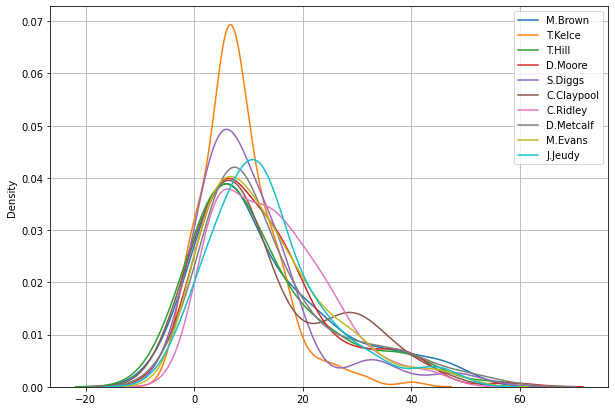

In [70]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.grid(True)

for receiver in pass_df['receiver_player_id'].unique():
    player_df = pass_df.loc[pass_df['receiver_player_id'] == receiver]
    air_yards_array = player_df['air_yards'].values
    sns.kdeplot(air_yards_array, ax=ax, label=player_df['receiver_player_name'].values[0])

ax.legend();

Target Shares per Receiver

In [71]:
target_df = pbp_df.groupby(['game_id', 'receiver_player_id', 'receiver_player_name', 'posteam'], as_index=False)['pass_attempt'].sum().sort_values(by='pass_attempt', ascending=False)

In [72]:
target_df.loc[target_df['receiver_player_id'].notnull()].groupby(['game_id', 'posteam'], as_index=False)['pass_attempt'].sum()

,game_id,posteam,pass_attempt
0,2020_01_ARI_SF,ARI,37.0
1,2020_01_ARI_SF,SF,32.0
2,2020_01_CHI_DET,CHI,36.0
3,2020_01_CHI_DET,DET,41.0
4,2020_01_CLE_BAL,BAL,25.0
...,...,...,...
533,2020_20_BUF_KC,KC,38.0
534,2020_20_TB_GB,GB,47.0
535,2020_20_TB_GB,TB,35.0
536,2020_21_KC_TB,KC,46.0


In [73]:
target_share_df = target_df.groupby(['game_id', 'receiver_player_id', 'receiver_player_name', 'posteam'], as_index=False)['pass_attempt'].sum().merge(
    target_df.loc[target_df['receiver_player_id'].notnull(), ['game_id', 'posteam', 'pass_attempt']].groupby(['game_id', 'posteam'], as_index=False).sum(), on=['game_id', 'posteam'], suffixes=('_player', '_team')
)

In [74]:
target_share_df['target_share'] = (target_share_df['pass_attempt_player'] / target_share_df['pass_attempt_team']) * 100

In [75]:
target_share_df = target_share_df.groupby(['receiver_player_id', 'receiver_player_name', 'posteam'], as_index=False)[['target_share', 'pass_attempt_player']].mean().sort_values(by='target_share', ascending=False)

In [76]:
target_share_df.head()

,receiver_player_id,receiver_player_name,posteam,target_share,pass_attempt_player
101,00-0031381,D.Adams,GB,33.484522,10.875000
113,00-0031588,S.Diggs,BUF,29.599295,10.421053
79,00-0030564,D.Hopkins,ARI,29.577656,10.062500
386,00-0034960,J.Meyers,NE,28.995889,6.833333
116,00-0031610,D.Waller,LV,27.972606,9.125000


Endzone Targets

In [77]:
endzone_targets_df = pbp_df.loc[pbp_df['pass_attempt'] == 1, ['yardline_100', 'air_yards', 'pass_touchdown', 'receiver_player_id', 'receiver_player_name', 'posteam']].assign(pass_loc=lambda x: x.yardline_100 - x.air_yards) 

endzone_targets_df.sort_values(by='pass_loc').head(10)

,yardline_100,air_yards,pass_touchdown,receiver_player_id,receiver_player_name,posteam,pass_loc
48509,10.0,10.0,0.0,00-0030506,T.Kelce,KC,0.0
36419,31.0,31.0,0.0,00-0036322,J.Jefferson,MIN,0.0
36412,48.0,48.0,1.0,00-0035298,S.Miller,TB,0.0
36405,14.0,14.0,0.0,00-0030035,A.Thielen,MIN,0.0
36326,37.0,37.0,0.0,00-0036245,M.Perry,MIA,0.0
36311,29.0,29.0,1.0,00-0034829,M.Gesicki,MIA,0.0
36305,24.0,24.0,0.0,00-0033040,T.Hill,KC,0.0
8294,1.0,1.0,1.0,00-0031408,M.Evans,TB,0.0
36257,44.0,44.0,1.0,00-0033040,T.Hill,KC,0.0
36244,6.0,6.0,0.0,00-0031325,S.Watkins,KC,0.0


In [78]:
endzone_targets_df = endzone_targets_df.dropna()

In [79]:
endzone_targets_df['endzone_target'] = endzone_targets_df['pass_loc'].apply(lambda x: x==0)

In [80]:
endzone_targets_df = endzone_targets_df.groupby(['receiver_player_id', 'receiver_player_name'], as_index=False)[['endzone_target', 'pass_touchdown']].sum().sort_values(by='endzone_target', ascending=False)

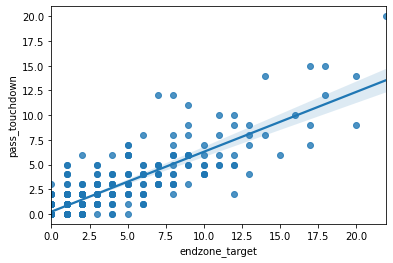

In [81]:
sns.regplot(x=endzone_targets_df['endzone_target'], y=endzone_targets_df['pass_touchdown']);

# Rushing Analysis

Visualizing Carries

In [82]:
rush_df = pbp_df[['rusher_player_id', 'rusher_player_name', 'yardline_100', 'rush_attempt']]

rush_df = rush_df[rush_df['rush_attempt'] == 1]

In [83]:
player_ids = rush_df['rusher_player_id'].unique()

rush_player_df = {
    'rusher_player_id': [],
    '1 - 10 yardline': [],
    '11 - 20 yardline': [],
    '21 - 30 yardline': [],
    '31 - 40 yardline': [],
    '41 - 60 yardline': [],
    '61 - 80 yardline': [],
    '81 - 100 yardline': []
}

for player_id in player_ids:
    player_df = rush_df.loc[rush_df['rusher_player_id'] == player_id]

    rushes = player_df['yardline_100'].tolist()

    if len(rushes) < 10:
        continue

    rush_player_df['rusher_player_id'].append(player_id)

    levels = {
        '1 - 10 yardline': (-1, 11),
        '11 - 20 yardline': (10, 21),
        '21 - 30 yardline': (20, 31),
        '31 - 40 yardline': (30, 41),
        '41 - 60 yardline': (40, 61),
        '61 - 80 yardline': (60, 81),
        '81 - 100 yardline': (80, 100)
    }

    for level, (min, max) in levels.items():
        num_level_touches = len(list(filter(lambda x: x> min and x < max, rushes)))

        rush_player_df[level].append(num_level_touches / len(rushes))

carries_dist = pd.DataFrame(rush_player_df)

carries_dist.head()

,rusher_player_id,1 - 10 yardline,11 - 20 yardline,21 - 30 yardline,31 - 40 yardline,41 - 60 yardline,61 - 80 yardline,81 - 100 yardline
0,00-0031687,0.067308,0.038462,0.105769,0.086538,0.163462,0.442308,0.096154
1,00-0033118,0.146444,0.087866,0.087866,0.079498,0.171548,0.334728,0.092050
2,00-0035228,0.111940,0.082090,0.111940,0.082090,0.298507,0.253731,0.059701
3,00-0029892,0.235294,0.058824,0.117647,0.117647,0.176471,0.176471,0.117647
4,00-0031376,0.098765,0.111111,0.049383,0.061728,0.246914,0.320988,0.111111


In [84]:
player_id_table = rush_df.loc[rush_df['rush_attempt'] == 1, ['rusher_player_id', 'rusher_player_name']].groupby(['rusher_player_id'], as_index=False).first()

player_id_table.head()

,rusher_player_id,rusher_player_name
0,00-0019596,T.Brady
1,00-0020531,D.Brees
2,00-0022787,M.Schaub
3,00-0022924,B.Roethlisberger
4,00-0022942,P.Rivers


In [85]:
carries_dist = carries_dist.merge(player_id_table, on='rusher_player_id')

carries_dist.head()

,rusher_player_id,1 - 10 yardline,11 - 20 yardline,21 - 30 yardline,31 - 40 yardline,41 - 60 yardline,61 - 80 yardline,81 - 100 yardline,rusher_player_name
0,00-0031687,0.067308,0.038462,0.105769,0.086538,0.163462,0.442308,0.096154,R.Mostert
1,00-0033118,0.146444,0.087866,0.087866,0.079498,0.171548,0.334728,0.092050,K.Drake
2,00-0035228,0.111940,0.082090,0.111940,0.082090,0.298507,0.253731,0.059701,K.Murray
3,00-0029892,0.235294,0.058824,0.117647,0.117647,0.176471,0.176471,0.117647,K.Juszczyk
4,00-0031376,0.098765,0.111111,0.049383,0.061728,0.246914,0.320988,0.111111,J.McKinnon


In [86]:
notable_players = pbp_df.loc[pbp_df['rush_attempt'] == 1, ['rusher_player_id', 'rusher_player_name', 'rush_touchdown']]

notable_players = notable_players.groupby(['rusher_player_id', 'rusher_player_name'], as_index=False)['rush_touchdown'].sum()

notable_players = notable_players.sort_values(by='rush_touchdown', ascending=False).head(30)

notable_players = notable_players[['rusher_player_id', 'rusher_player_name']]

notable_players

,rusher_player_id,rusher_player_name
118,00-0032764,D.Henry
184,00-0033906,A.Kamara
181,00-0033893,D.Cook
241,00-0034791,N.Chubb
343,00-0036223,J.Taylor
316,00-0035700,J.Jacobs
24,00-0027939,C.Newton
278,00-0035228,K.Murray
361,00-0036328,A.Gibson
143,00-0033118,K.Drake


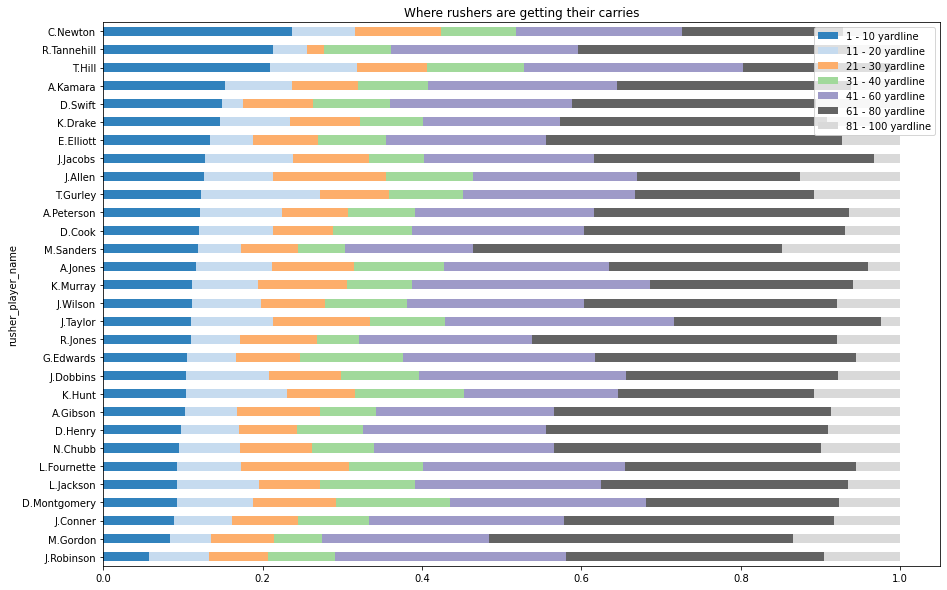

In [87]:
carries_dist_copy = carries_dist.copy()

carries_dist_copy = carries_dist_copy.loc[carries_dist_copy['rusher_player_id'].isin(notable_players['rusher_player_id'])]

carries_dist_copy = carries_dist_copy.set_index('rusher_player_name')

carries_dist_copy = carries_dist_copy.sort_values(by='1 - 10 yardline')

ax= carries_dist_copy.plot.barh(stacked=True, colormap='tab20c')

fig = plt.gcf()

fig.set_size_inches(15, 10)

ax.legend(loc=1)

ax.set_title('Where rushers are getting their carries');

# Passing Analysis

EPA per Dropback

In [88]:
search_columns('epa')

epa
total_home_epa
total_away_epa
total_home_rush_epa
total_away_rush_epa
total_home_pass_epa
total_away_pass_epa
air_epa
yac_epa
comp_air_epa
comp_yac_epa
total_home_comp_air_epa
total_away_comp_air_epa
total_home_comp_yac_epa
total_away_comp_yac_epa
total_home_raw_air_epa
total_away_raw_air_epa
total_home_raw_yac_epa
total_away_raw_yac_epa
qb_epa
xyac_epa


In [89]:
epa_df = pbp_df.loc[pbp_df['pass_attempt'] == 1, ['passer_player_id', 'passer_player_name', 'pass_attempt', 'qb_epa']]

epa_df = epa_df.groupby(['passer_player_id', 'passer_player_name'], as_index=False).sum()

epa_df['epa/dropback'] = epa_df['qb_epa'] / epa_df['pass_attempt']

epa_df.loc[epa_df['pass_attempt'] > 50].sort_values(by='epa/dropback', ascending=False).head(10)

,passer_player_id,passer_player_name,pass_attempt,qb_epa,epa/dropback
6,00-0023459,A.Rodgers,637.0,209.550069,0.328964
73,00-0033873,P.Mahomes,734.0,203.699703,0.277520
33,00-0029701,R.Tannehill,534.0,125.785390,0.235553
88,00-0034857,J.Allen,728.0,168.458989,0.231400
0,00-0019596,T.Brady,777.0,171.631459,0.220890
69,00-0033537,D.Watson,597.0,131.655955,0.220529
4,00-0022942,P.Rivers,611.0,119.250387,0.195172
87,00-0034855,B.Mayfield,585.0,104.697378,0.178970
7,00-0023682,R.Fitzpatrick,283.0,48.693218,0.172061
31,00-0029604,K.Cousins,562.0,95.060423,0.169147


In [90]:
search_columns('scramble')

qb_scramble


In [91]:
scrambles = pbp_df.loc[pbp_df['qb_scramble'] == 1, ['rusher_player_id', 'rush_attempt', 'epa']]

scrambles = scrambles.groupby(['rusher_player_id'], as_index=False).sum()

scrambles = scrambles.rename(columns={
    'rusher_player_id': 'passer_player_id',
    'epa': 'scramble_epa',
    'rush_attempt': 'scrambles'
})

epa_df = epa_df.merge(scrambles, on='passer_player_id')

epa_df.head()

,passer_player_id,passer_player_name,pass_attempt,qb_epa,epa/dropback,scrambles,scramble_epa
0,00-0019596,T.Brady,777.0,171.631459,0.220890,4.0,-2.096755
1,00-0020531,D.Brees,477.0,63.825985,0.133807,2.0,-1.796676
2,00-0022924,B.Roethlisberger,696.0,62.410035,0.089670,3.0,1.105452
3,00-0022942,P.Rivers,611.0,119.250387,0.195172,1.0,-0.330987
4,00-0023436,A.Smith,274.0,-32.707833,-0.119372,3.0,-0.922623


In [92]:
epa_df['total_dropbacks'] = epa_df['pass_attempt'] + epa_df['scrambles']

epa_df['total_epa'] = epa_df['qb_epa'] + epa_df['scramble_epa']

epa_df['true_epa/dropback'] = epa_df['total_epa'] / epa_df['total_dropbacks']

In [93]:
epa_df = epa_df.loc[epa_df['pass_attempt'] > 50, ['passer_player_name', 'true_epa/dropback']].sort_values(by='true_epa/dropback').reset_index(drop=True)

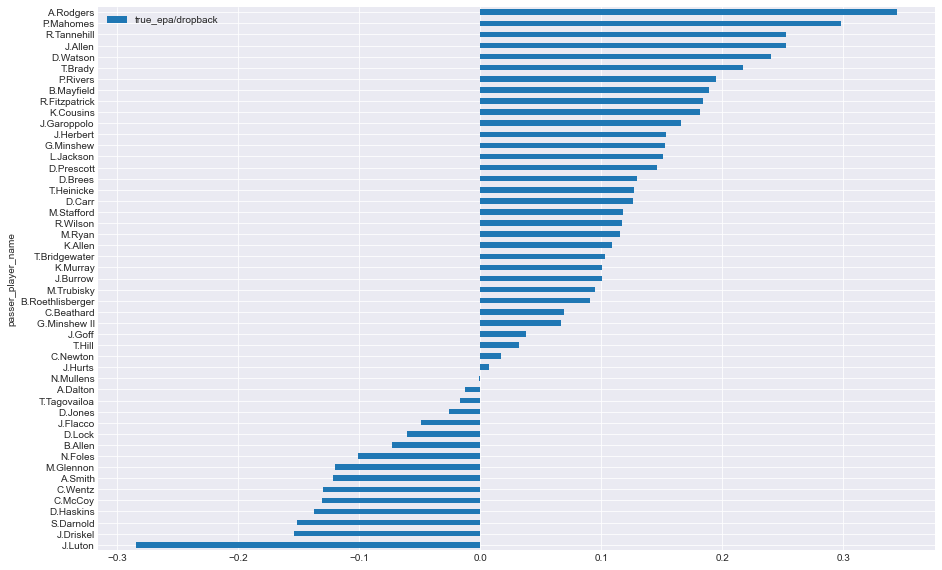

In [94]:
plt.style.use('seaborn-darkgrid')

ax = epa_df.set_index('passer_player_name').plot.barh()

fig = plt.gcf(); fig.set_size_inches(15, 10)